In [1]:
# =========================================================
# 0) Setup: libs & folder
# =========================================================
import os, sys, zipfile, io, gzip, shutil, textwrap, json, math, datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

os.makedirs("outputs", exist_ok=True)
print("Environment ready.")

Environment ready.


In [2]:
# =========================================================
# 1) Unduh dataset dari MIT CSAIL
#    Sumber resmi: https://db.csail.mit.edu/labdata/labdata.html
#    File: data.txt.gz (2.3M baris), mote_locs.txt (koordinat)
# =========================================================
!wget -q -O data.txt.gz https://db.csail.mit.edu/labdata/data.txt.gz
!wget -q -O mote_locs.txt https://db.csail.mit.edu/labdata/mote_locs.txt

# Cek ukuran file
import os
print("data.txt.gz size (MB):", round(os.path.getsize("data.txt.gz")/1e6, 2))
print("mote_locs.txt size (KB):", round(os.path.getsize("mote_locs.txt")/1e3, 2))

data.txt.gz size (MB): 34.42
mote_locs.txt size (KB): 0.55


In [3]:
# =========================================================
# 2) Load data: parsing kolom sesuai skema resmi
#    Skema: date, time, epoch, moteid, temperature, humidity, light, voltage
# =========================================================
def load_ibrl_gz(path_gz, nrows=None):
    cols = ["date","time","epoch","moteid","temperature","humidity","light","voltage"]
    df = pd.read_csv(
        path_gz,
        sep=r"\s+",
        header=None,
        names=cols,
        engine="python",
        nrows=nrows  # set ke None untuk full
    )
    # Gabung date+time -> datetime
    df["timestamp"] = pd.to_datetime(df["date"] + " " + df["time"], errors="coerce")
    df = df.drop(columns=["date","time"])
    # Urutkan
    df = df.sort_values(["timestamp","moteid"]).reset_index(drop=True)
    return df

# NOTE: dataset penuh ~2.3 juta baris → bisa makan RAM.
# Untuk eksplor cepat pakai subset, nanti ganti nrows=None untuk full run.
df = load_ibrl_gz("data.txt.gz", nrows=500_000)  # coba set 500k dulu biar responsif
df.head()


,epoch,moteid,temperature,humidity,light,voltage,timestamp
0,2,3,20.2040,36.8871,50.60,2.69964,2004-02-28 00:58:46.497331
1,2,6,20.4196,36.6118,121.44,2.65143,2004-02-28 00:58:46.657464
2,3,1,19.9884,37.0933,45.08,2.69964,2004-02-28 00:59:16.027850
3,4,12,17.8030,41.7805,90.16,2.66332,2004-02-28 00:59:46.120334
4,6,6,19.9002,37.5737,121.44,2.63964,2004-02-28 01:00:46.525723


In [4]:
# =========================================================
# 3) Load koordinat sensor (mote_locs.txt)
#    Format: "id x y" berurutan dalam satu baris → kita rapihkan ke DataFrame 3 kolom
# =========================================================
with open("mote_locs.txt","r") as f:
    raw = f.read().strip().split()

triples = list(zip(*(iter(raw),)*3))  # (id,x,y) tuples
locs = pd.DataFrame(triples, columns=["moteid","x","y"]).astype(float)
locs["moteid"] = locs["moteid"].astype(int)
locs.head()


,moteid,x,y
0,1,21.5,23.0
1,2,24.5,20.0
2,3,19.5,19.0
3,4,22.5,15.0
4,5,24.5,12.0


In [5]:
# =========================================================
# 4) Merge data + lokasi, fitur waktu
# =========================================================
df = df.merge(locs, on="moteid", how="left")

# Fitur waktu
df["hour"]   = df["timestamp"].dt.hour
df["minute"] = df["timestamp"].dt.minute
df["dow"]    = df["timestamp"].dt.dayofweek   # 0=Mon
df["day"]    = df["timestamp"].dt.day
df["date"]   = df["timestamp"].dt.date

# Konversi tipe
for c in ["temperature","humidity","light","voltage","x","y"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Simpan sampel EDA
df.head(50).to_csv("outputs/sample_head50.csv", index=False)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   epoch        500000 non-null  int64         
 1   moteid       500000 non-null  int64         
 2   temperature  500000 non-null  float64       
 3   humidity     499943 non-null  float64       
 4   light        499943 non-null  float64       
 5   voltage      483428 non-null  float64       
 6   timestamp    499999 non-null  datetime64[ns]
 7   x            500000 non-null  float64       
 8   y            500000 non-null  float64       
 9   hour         499999 non-null  float64       
 10  minute       499999 non-null  float64       
 11  dow          499999 non-null  float64       
 12  day          499999 non-null  float64       
 13  date         499999 non-null  object        
dtypes: datetime64[ns](1), float64(10), int64(2), object(1)
memory usage: 53.4+ MB


Missing values per column:
 epoch              0
moteid             0
temperature        0
humidity          57
light             57
voltage        16572
timestamp          1
x                  0
y                  0
hour               1
minute             1
dow                1
day                1
date               1
dtype: int64


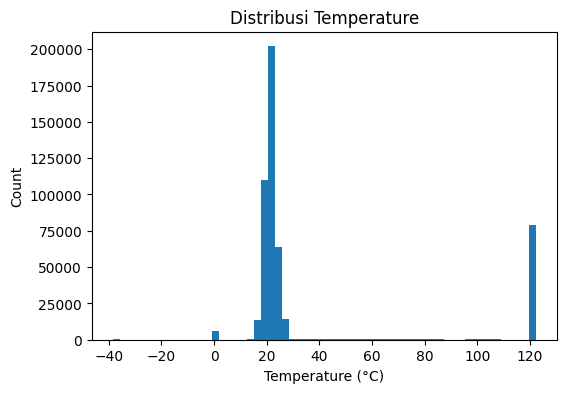

,temperature,humidity,light,voltage,x,y,hour,minute,dow,day
temperature,1.000000,-0.621361,0.005569,-0.753966,0.037101,-0.011460,0.031669,-0.000070,-0.020073,0.496462
humidity,-0.621361,1.000000,-0.036504,0.541975,-0.078028,-0.031495,-0.021827,0.001928,0.004713,-0.317168
light,0.005569,-0.036504,1.000000,0.050803,-0.045908,-0.264799,0.050864,-0.003016,0.022611,0.014079
voltage,-0.753966,0.541975,0.050803,1.000000,-0.016566,-0.057746,0.027293,0.000467,-0.009563,-0.602494
x,0.037101,-0.078028,-0.045908,-0.016566,1.000000,0.445855,0.001495,-0.001209,0.012612,0.034238
y,-0.011460,-0.031495,-0.264799,-0.057746,0.445855,1.000000,0.003651,-0.001426,0.012035,0.050881
hour,0.031669,-0.021827,0.050864,0.027293,0.001495,0.003651,1.000000,0.001862,0.031641,0.008165
minute,-0.000070,0.001928,-0.003016,0.000467,-0.001209,-0.001426,0.001862,1.000000,-0.000806,-0.001163
dow,-0.020073,0.004713,0.022611,-0.009563,0.012612,0.012035,0.031641,-0.000806,1.000000,0.292022
day,0.496462,-0.317168,0.014079,-0.602494,0.034238,0.050881,0.008165,-0.001163,0.292022,1.000000


In [6]:
# =========================================================
# 5) EDA ringkas
# =========================================================
print("Missing values per column:\n", df.isna().sum())

# Distribusi temperature
plt.figure(figsize=(6,4))
plt.hist(df["temperature"].dropna(), bins=60)
plt.title("Distribusi Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("Count")
plt.show()

# Korelasi numerik
num_cols = ["temperature","humidity","light","voltage","x","y","hour","minute","dow","day"]
corr = df[num_cols].corr()
corr.to_csv("outputs/correlation.csv")
corr


In [7]:
# =========================================================
# 6) Preprocessing & fitur tambahan
#    - Drop baris dengan missing pada fitur target/fitur utama
#    - Buat lag fitur per-mote (opsional untuk memperkuat prediksi)
# =========================================================
# Percepat: pakai subset motes agar lag tidak boros RAM (opsional)
# df = df[df["moteid"].isin(range(1, 20))].copy()

# Buat lag (1 langkah) untuk setiap mote
df = df.sort_values(["moteid","timestamp"])
for col in ["temperature","humidity","light","voltage"]:
    df[f"{col}_lag1"] = df.groupby("moteid")[col].shift(1)

# Drop NA penting
features = [
    "humidity","light","voltage","x","y","hour","minute","dow",
    "temperature_lag1","humidity_lag1","light_lag1","voltage_lag1"
]
df_model = df.dropna(subset=["temperature"] + features).copy()

X = df_model[features]
y = df_model["temperature"]

print(X.shape, y.shape)


(483134, 12) (483134,)


In [8]:
# =========================================================
# 7) Split & scaling
# =========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

print("Train/Test:", X_train.shape, X_test.shape)


Train/Test: (386507, 12) (96627, 12)


In [19]:
# =========================================================
# 8) Train tiga model: Linear, RF, GB
# =========================================================
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=300, random_state=42)
}

results = {}
pred_store = {}

for name, model in models.items():
    if name == "LinearRegression":
        model.fit(X_train_s, y_train)
        preds = model.predict(X_test_s)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds)
    r2   = r2_score(y_test, preds)
    results[name] = {"RMSE": rmse, "R2": r2}
    pred_store[name] = preds
    print(f"{name:18s}  RMSE={rmse:.3f}  R2={r2:.3f}")

# Simpan hasil
pd.DataFrame(results).T.to_csv("outputs/model_results.csv")
best_name = min(results, key=lambda k: results[k]["RMSE"])
best_name

LinearRegression    RMSE=42.095  R2=0.970


KeyboardInterrupt: 

In [21]:
# =========================================================
# 9) Simpan prediksi contoh & feature importance (bila ada)
# =========================================================
# Define best_name based on existing results if available
if results:
  best_name = min(results, key=lambda k: results[k]["RMSE"])
else:
  best_name = None # Or handle the case where results is empty

if best_name:
    best_preds = pred_store[best_name]
    pred_df = pd.DataFrame({
        "y_true": y_test.values,
        "y_pred": best_preds
    })
    pred_df.to_csv("outputs/predictions_example.csv", index=False)

    # Feature importance RF (kalau RF terbaik)
    if "RandomForest" in models and best_name == "RandomForest":
        rf = models["RandomForest"]
        if hasattr(rf, "feature_importances_"):
            fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
            fi.to_csv("outputs/feature_importances_rf.csv")
            # Plot top-10
            topn = fi.head(10)
            plt.figure(figsize=(7,4))
            topn.plot(kind="bar")
            plt.title("Top-10 Feature Importances (RandomForest)")
            plt.tight_layout()
            plt.show()
else:
    print("No model results available to determine the best model.")

In [22]:
# =========================================================
# 10) Simpan README ringkas + arsip ZIP (program+output+dataset info)
# =========================================================
readme = f"""
Intel Berkeley Research Lab (IBRL) – Temperature Prediction
==========================================================

Sumber data: MIT CSAIL Intel Lab Data (54 motes, 2.3M rows, 2004).
File asli: data.txt.gz, mote_locs.txt (diunduh otomatis).

Tujuan:
- Prediksi temperature menggunakan humidity, light, voltage, waktu, dan koordinat sensor.
- EDA singkat: distribusi, korelasi.

Algoritma:
- LinearRegression (baseline), RandomForest, GradientBoosting.
- Evaluasi: RMSE dan R² pada hold-out test 20%.

Catatan:
- Dibuat fitur waktu (hour/minute/dow/day) dan lag-1 per mote.
- Hasil lengkap lihat outputs/model_results.csv dan outputs/predictions_example.csv.

Cara re-run:
- Jalankan notebook dari awal. Untuk full data ganti nrows=None pada load_ibrl_gz().
"""

with open("README_IBRL.md","w") as f:
    f.write(readme)

# Zip paket
zip_name = "ibrl_analysis_package.zip"
with zipfile.ZipFile(zip_name, "w", zipfile.ZIP_DEFLATED) as z:
    for path in ["README_IBRL.md","data.txt.gz","mote_locs.txt"]:
        if os.path.exists(path):
            z.write(path)
    for root, _, files in os.walk("outputs"):
        for fn in files:
            z.write(os.path.join(root, fn))
print("ZIP siap:", zip_name)


ZIP siap: ibrl_analysis_package.zip


In [44]:
# Install git di Colab
!apt-get install git -y

# Setting git config
!git config --global user.email "jakyirsyad635@gmail.com"
!git config --global user.name "jakyirsyad"

# Clone repo kamu (https://github.com/jakyirsyad/MACHINELEARNING565.git)
# Format URL: https://github.com/jakyirsyad/MACHINELEARNING565.git
TOKEN = "git@github.com:jakyirsyad/MACHINELEARNING565.git"
USERNAME = "jakyirsyad"
REPO = "MACHINELEARNING565"

!git clone https://github.com/jakyirsyad/MACHINELEARNING565.git


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.15).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
fatal: destination path 'MACHINELEARNING565' already exists and is not an empty directory.


In [52]:
import os

os.chdir(f"/content/{MACHINELEARNING565}")
!git add .
!git commit -m "Upload hasil analisis forestfires"
!git push origin main


NameError: name 'MACHINELEARNING565' is not defined